# Check GPU

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Import Libraries

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import skimage
from skimage.io import imread, imshow

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import random
import skimage
from skimage.io import imread, imshow
from keras.preprocessing.image import ImageDataGenerator

# Define parameters & Training Path

In [ ]:
height = 210
width = 210
crop = 210

best_model_name = 'HRD_EfficientNetB0_MOd_Mcc_loss_test1.h5'
factor=0.93
patience=2
epoch=200

In [ ]:
TRAIN_PATH = r'/content/drive/MyDrive/Dataset/C-NMC/High Imbalance/Train - 1 to 100 ratio'
BATCH_SIZE=10
r = 4
c = 4

# Define Image Crop Functions

In [ ]:
def crop_center(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = crop_center(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

# Implement Image Data Generator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_batches = train_datagen.flow_from_directory(TRAIN_PATH,
                                                  class_mode='binary',
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  target_size=(450, 450),
                                                  shuffle=True,
                                                  seed=42
                                                  )

train_crops = crop_generator(train_batches, crop)

Found 3423 images belonging to 2 classes.


# Sample Images

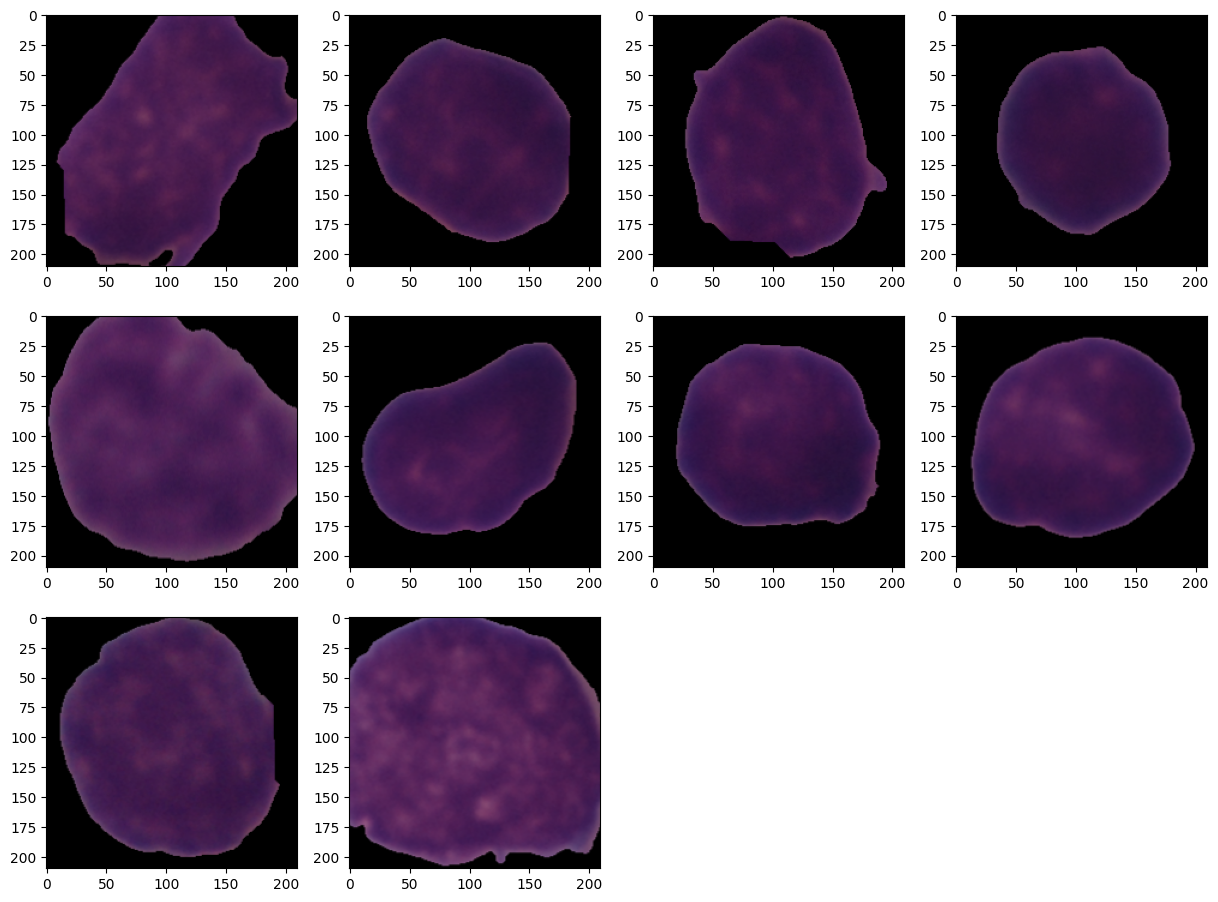

In [ ]:
train_crops
x , y = next(train_crops)
plt.figure(figsize=(15,15))
i=0
for img in x:
    plt.subplot(r,c,i+1)
    plt.imshow(img)
    i+=1

111 0


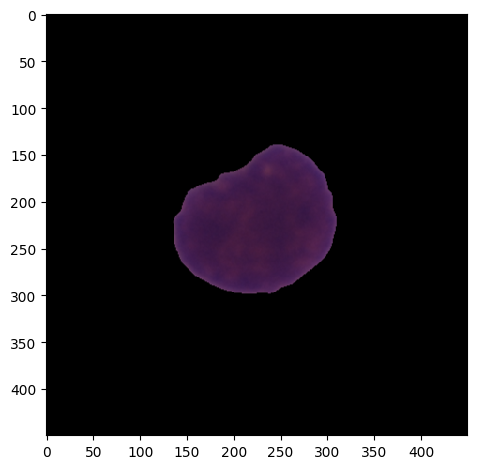

In [ ]:
import skimage
from skimage.io import imread, imshow
import numpy as np

img = imread(r'/content/drive/MyDrive/Dataset/C-NMC/Moderate Imbalance/Test/hem/1002.bmp')
imshow(img)
print(np.max(img), np.min(img))

# Implement Resnet50 Model

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, GlobalAveragePooling2D


In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(height,width,3),
    pooling=None,
    classes=1,
    classifier_activation="sigmoid",
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
prediction = Dense(1, activation=tf.nn.sigmoid)(x)

model = Model(inputs=base_model.input,outputs=prediction)

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 210, 210, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 216, 216, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 105, 105, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 105, 105, 64)         256       ['conv1_conv[0][0]']          
 on)                         

# Implement MCC Loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mcc_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) * 1e2
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) / 1e2

    up = tp*tn - fp*fn
    down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))

    mcc = up / (down + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)

    return 1 - K.mean(mcc)

# Compile The Model with Adam Optimizer

In [ ]:
import tensorflow as tf


adam_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.0, beta_2=0.0, amsgrad=True)


model.compile(optimizer= adam_opt,
              loss = [mcc_loss],
              metrics=['accuracy'])

# Define The Callback Function

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
best_model_name = best_model_name
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(best_model_name, monitor='accuracy', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=factor, verbose=1, patience=patience, mode='max')]

# Train The Model

In [ ]:
history  = model.fit(train_crops,
         steps_per_epoch=train_batches.n//train_batches.batch_size,
         epochs=epoch,
         verbose=1,
         callbacks = callbacks)

Epoch 1/200
342/342 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.3660

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


342/342 [==============================] - 149s 272ms/step - loss: 0.9317 - accuracy: 0.3660 - lr: 0.0010
Epoch 2/200
342/342 [==============================] - 47s 137ms/step - loss: 0.9162 - accuracy: 0.3094 - lr: 0.0010
Epoch 3/200
342/342 [==============================] - 46s 135ms/step - loss: 0.9115 - accuracy: 0.3803 - lr: 0.0010
Epoch 4/200
342/342 [==============================] - 45s 130ms/step - loss: 0.9167 - accuracy: 0.1735 - lr: 0.0010
Epoch 5/200
342/342 [==============================] - ETA: 0s - loss: 0.9086 - accuracy: 0.2060
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009300000441726298.
342/342 [==============================] - 46s 135ms/step - loss: 0.9086 - accuracy: 0.2060 - lr: 0.0010
Epoch 6/200
342/342 [==============================] - 45s 132ms/step - loss: 0.9156 - accuracy: 0.2722 - lr: 9.3000e-04
Epoch 7/200
342/342 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.3197
Epoch 7: ReduceLROnPlateau reducing learning ra

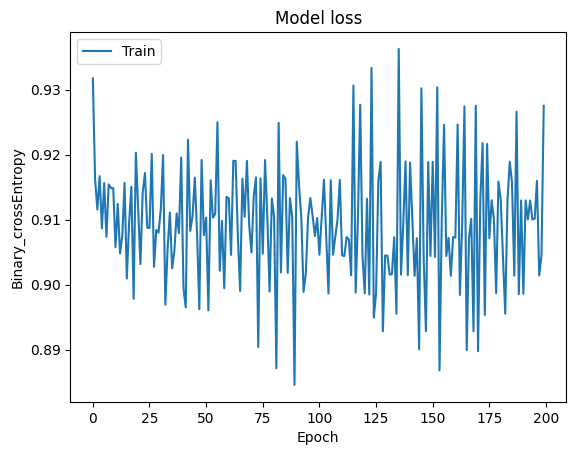

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

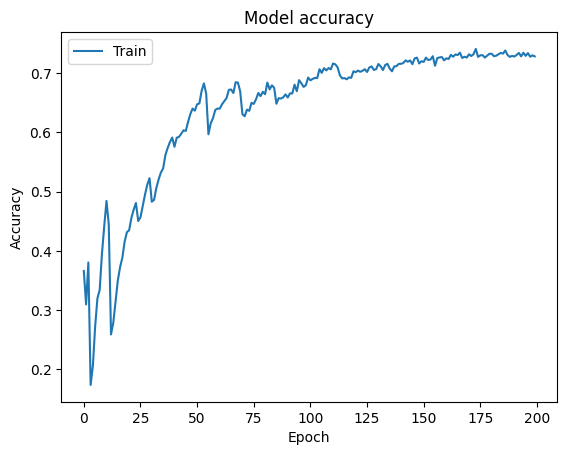

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
val_all_path = r'/content/drive/MyDrive/Dataset/C-NMC/High Imbalance/Test/all'
val_hem_path = r'/content/drive/MyDrive/Dataset/C-NMC/High Imbalance/Test/hem'

val_all_list = os.listdir(val_all_path)

val_hem_list = os.listdir(val_hem_path)


print('val/all_list_length: ', len(val_all_list))
print('val/hem_list_length :', len(val_hem_list))

val_all_batch = np.zeros((len(val_all_list), height, width, 3), dtype=np.uint8)
val_hem_batch = np.zeros((len(val_hem_list), height, width, 3), dtype=np.uint8)

print('val_all_batch shape: ', val_all_batch.shape, 'val_hem_batch shape: ', val_hem_batch.shape)


def Read_n_Crop(list_data, batch, path):
    i=0
    for x in list_data:
        image = cv2.imread(os.path.join(path, x))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = crop_center(image, (height,width,3))
        batch[i] = image
        i+=1

    print('batch type: ', type(batch), 'batch shape: ', batch.shape, 'batch dtype: ', batch.dtype, 'batch[0] shape: ', batch[0].shape, 'batch[0] dtype: ', batch[0].dtype)
    return batch


def crop_center(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

parasite_images=Read_n_Crop(val_all_list, val_all_batch, val_all_path)
uninf_images=Read_n_Crop(val_hem_list, val_hem_batch, val_hem_path)


para_label = np.array([0 for _ in range(len(parasite_images))])
uninf_label = np.array([1 for _ in range(len(uninf_images))])

print('parasite/all_label shape: ', para_label.shape, 'uninf_label shape: ', uninf_label.shape)

x_all = np.concatenate((parasite_images, uninf_images), axis=0)
y_all = np.concatenate((para_label, uninf_label), axis=0)
print('After concatenation.............................')
print('x_all shape: ', x_all.shape, 'y_all shape: ', y_all.shape)


model.load_weights(os.path.join(os.getcwd(), best_model_name))

x_all=x_all/255.0

y_pred = model.predict(x_all, verbose=1)
print("Predictions: ", y_pred.shape)

y_pred_flat = []
for pred in y_pred:
    if pred > 0.5:
        y_pred_flat.append(1)
    else:
        y_pred_flat.append(0)
y_pred_flat = np.array(y_pred_flat)

val/all_list_length:  1219
val/hem_list_length : 648
val_all_batch shape:  (1219, 210, 210, 3) val_hem_batch shape:  (648, 210, 210, 3)
batch type:  <class 'numpy.ndarray'> batch shape:  (1219, 210, 210, 3) batch dtype:  uint8 batch[0] shape:  (210, 210, 3) batch[0] dtype:  uint8
batch type:  <class 'numpy.ndarray'> batch shape:  (648, 210, 210, 3) batch dtype:  uint8 batch[0] shape:  (210, 210, 3) batch[0] dtype:  uint8
parasite/all_label shape:  (1219,) uninf_label shape:  (648,)
After concatenation.............................
x_all shape:  (1867, 210, 210, 3) y_all shape:  (1867,)
59/59 [==============================] - 10s 110ms/step
Predictions:  (1867, 1)


In [ ]:
print('Samples classified as all / 1219: ', y_pred_flat.tolist().count(0))
print('Samples classified as hem / 648: ', y_pred_flat.tolist().count(1))

Samples classified as all / 1219:  1464
Samples classified as hem / 648:  403


In [ ]:
np.unique(y_pred_flat)

array([0, 1])

In [ ]:
print(y_pred_flat.tolist().count(0), y_pred_flat.tolist().count(1))

1464 403


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


confusion_mtx = confusion_matrix(y_all, y_pred_flat)
print(confusion_mtx)
target_names = ['0', '1']
report = classification_report(y_all, y_pred_flat, target_names=target_names, digits=4)
print(classification_report(y_all, y_pred_flat, target_names=target_names, digits=4))

[[1084  135]
 [ 380  268]]
              precision    recall  f1-score   support

           0     0.7404    0.8893    0.8081      1219
           1     0.6650    0.4136    0.5100       648

    accuracy                         0.7242      1867
   macro avg     0.7027    0.6514    0.6590      1867
weighted avg     0.7143    0.7242    0.7046      1867

